# Title - LSTM ARTICLE RIOT investment Club

Objective: recreate the results of the paper "LSTM for financial timeseries" by Carmina Fjellström. [link](https://github.com/the-future-dev/riot-lstm-article/blob/main/docs/LSTM%20for%20financial%20time%20series.pdf)



In [ ]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## DATA
Data fetching:
- stocks from Stockhom’s OMX30
- time period from May 2002 to January 2020

Data refactoring:
- DATA: percentage change of the closing price:
  - formula: 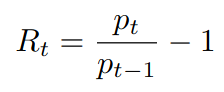
- TARGET: classification with 0 / 1 if the return is below or above the daily median

If data is already present in the folder, let's just load it.

In [ ]:
# Stockhom’s OMX30 tickers
start = '2002-05-01'
end = '2020-01-01'
omx_stockholm_30_tickers = [
    "ABB.ST",
    "ALFA.ST",
    "ASSA-B.ST",
    "AZN.ST",
    "ATCO-A.ST", "ATCO-B.ST",
    "AZN.ST",
    "ALIV-SDB.ST",
    "BOL.ST",
    "ELUX-B.ST",
    "ERIC-B.ST",
    "ESSITY-B.ST",
    "EVO.ST",
    "GETI-B.ST",
    "HEXA-B.ST",
    "HM-B.ST",
    "INVE-B.ST",
    "KINV-B.ST",
    "NIBE-B.st",
    "NDA-SE.ST",
    "SBB-B.ST",
    "SAND.ST",
    "SEB-A.ST",
    "SINCH.ST",
    "SKF-B.ST",
    "SHB-A.ST",
    "SWED-A.ST",
    "TEL2-B.ST",
    "TELIA.ST",
    "VOLV-B.ST"
    ]

file_path_name = 'data/data.csv'
number_of_stocks = len(omx_stockholm_30_tickers)

def save_data(start, end, file_path_name, tickers):
    df = None
    i = 1

    for ticker in tickers:
        data = yf.download(ticker, period='1d', start=start, end=end)
        data[f'stock_{i}'] = data['Close'].pct_change()
        close_x = data[f'stock_{i}']
        if df is None:
            df = close_x
        else:
            df = pd.concat([df, close_x], axis=1)
        i = i+1

    df['Medians'] = df.median(axis=1, skipna=True)

    for j in range(1, i):
        df[f'target_{j}'] = np.where(df[f'stock_{j}'].isna(), np.nan, np.where(df[f'stock_{j}'] > df['Medians'], 1, 0))

    df.to_csv(file_path_name, index=False)


# save_data(start, end, file_path_name, omx_stockholm_30_tickers)
data = pd.read_csv(file_path_name)

data.shape

## Training and Testing
The data for each stock were divided into blocks of length 750 days for training (approximately three years of trading), 270 days for valuation (more than a year of trading), and 270 days for testing.

**ATM: just first block.**

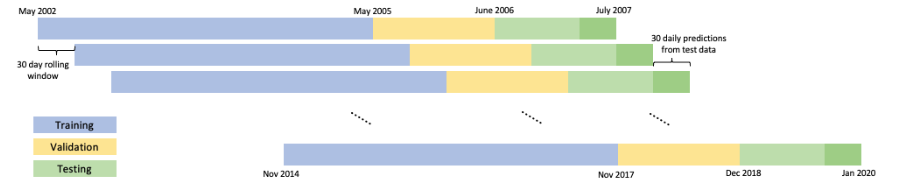

In [ ]:
sequence_length = 150 # 240
features = 1 # as feature we are using the label "target" for each stock
rolling_window = 30

sequences = None
targets = None

def create_sequences(data_, target_, sequence_length, step):
    """
    Function to create the sequence
    """
    X, y = [], []
    
    assert(data_.shape[0] == target_.shape[0])

    # print(f'data shape: {data_.shape}, target shape; {target_.shape}')
    for start in range(0, len(data_) - sequence_length, step):
        end = start + sequence_length
        idx_target = end
        # print(f'\t>data idx: [{start},{end}], target idx: {end}')
        X.append(data_.iloc[start:end].values)
        y.append(target_.iloc[idx_target])
    
    return np.array(X), np.array(y)

block_training = sequence_length + rolling_window*2
block_validation = sequence_length + rolling_window*1 + block_training
block_testing = sequence_length + rolling_window *1 + block_validation

train_sequences, train_targets, valid_sequences, valid_targets, testg_sequences, testg_targets = None, None, None, None, None, None
for i in range(1, 31):
    stock_1 = data[f'stock_{i}'].dropna()
    label_1 = data[f'target_{i}'].dropna()
    # print(f'Stock {i}:')
    assert(stock_1.shape == label_1.shape)

    if (stock_1.shape[0] < block_testing):
        print(f"\tSkipped {i}")
        print(stock_1.shape[0])
        break

    train_sequences_i, train_targets_i = create_sequences(stock_1[:block_training], label_1[:block_training], sequence_length, rolling_window)
    valid_sequences_i, valid_targets_i = create_sequences(stock_1[block_training:block_validation], label_1[block_training:block_validation], sequence_length, rolling_window)
    testg_sequences_i, testg_targets_i = create_sequences(stock_1[block_validation:block_testing], label_1[block_validation:block_testing], sequence_length, rolling_window)
    if (train_sequences is None):
        train_sequences, train_targets = train_sequences_i, train_targets_i
        valid_sequences, valid_targets = valid_sequences_i, valid_targets_i
        testg_sequences, testg_targets = testg_sequences_i, testg_targets_i
    else:
        train_sequences = np.concatenate((train_sequences, train_sequences_i), axis=0)
        train_targets = np.concatenate((train_targets, train_targets_i), axis=0)
        valid_sequences = np.concatenate((valid_sequences, valid_sequences_i), axis=0)
        valid_targets = np.concatenate((valid_targets, valid_targets_i), axis=0)
        testg_sequences = np.concatenate((testg_sequences, testg_sequences_i), axis=0)
        testg_targets = np.concatenate((testg_targets, testg_targets_i), axis=0)

count_0 = (train_targets == 0).sum()
count_1 = (train_targets == 1).sum()
print(f'final 0: {count_0}, 1: {count_1}')


In [ ]:
# DOBULE CHECKING WITH CSV:
#> train_sequences[0][i] # -> A3:A242
#> train_targets[0] #-> AF243 hence the next day, as required=> VALID!

# TESTS for data refactoring:
test_sequences.shape[0]

## Network Architecture

The LSTM model consists of one input neuron, one hidden layer, and one output neuron.

A sigmoid activation function is used for the output, which can be interpreted as a measure of confidence.
- Closer to 1 means that the model is more confident that the return will be above the median,
- while closer to 0 means it is more confident that it will be below.

Adam optimizer was used together with a learning rate of 0.0075, which was chosen with the help of Bayesian optimization.

Instead of just one LSTM we will use several, all independent of each other and trained in parallel as showed in the figure below:

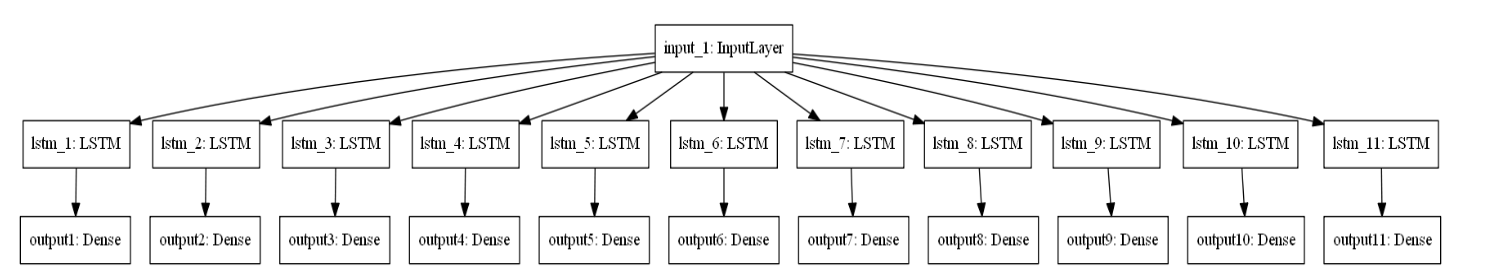

In [ ]:
def create_lstm_model(initializer):
    model = Sequential([
        LSTM(3, input_shape=(sequence_length, features), dropout=0.06, recurrent_dropout=0.14, kernel_initializer=initializer),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.0075)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

initializers = [
    RandomNormal(mean=0.0, stddev=0.05),
    RandomUniform(minval=-0.04, maxval=0.05),
    TruncatedNormal(mean=0.0, stddev=0.05),
    Zeros(),
    Ones(),
    GlorotNormal(),
    GlorotUniform(),
    Identity(),
    Orthogonal(),
    Constant(value=0.05),
    VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal')
]

models = [create_lstm_model(init) for init in initializers]



The same Bayesian optimization algorithm was also used to determine the values of the other hyperparameters to be:
- number of neurons in hidden layer = 3
- dropout = 0.06
- recurrent dropout = 0.14
- batch size = 6800


In [ ]:
batch_size = 6800
epochs = 2

for i, model in enumerate(models):
    print(f"Training model {i+1}...")
    model.fit(train_sequences, train_targets,
                batch_size = batch_size,
                epochs = epochs,
                validation_data = (valid_sequences, valid_targets))

In [ ]:
all_predictions = []

i = 1
for model in models:
    predictions = model.predict(testg_sequences)
    all_predictions.append(predictions.flatten())
    if i==-1:
        print(predictions)
    i=i+1

# Array of predictions by model shape (11, n)
all_predictions_array = np.array(all_predictions)


minimum_accuracy = 0.50939
threshold = 8
predicted_allocation = []

# The transponsed matrix is in shape (test_shape, number_of_model), meaning that for each entry there is an array containig the model predictions. Shape: (n, 11)
transposed_predictions_array = all_predictions_array.transpose()

for sub_array in transposed_predictions_array:
    count_above_threshold = np.sum(sub_array > minimum_accuracy)
    if count_above_threshold >= threshold:
        predicted_allocation.append(1)
    else:
        predicted_allocation.append(0)

predicted_allocation = np.array(predicted_allocation)

In [ ]:
y_pred_classes = predicted_allocation
y_true = testg_targets

conf_matrix = confusion_matrix(y_true, y_pred_classes)

accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)